In [1]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
from torchvision import models
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
from sklearn.metrics import confusion_matrix

In [3]:
if(os.path.split(os.getcwd())[1] == "Transfer_Learning"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

cuda = False

Current Working Directory: progettoVIPM


In [4]:
from utils.loadersAndEnums import datasets
from utils.loadersAndEnums import networks
from utils.loadersAndEnums import ImageDataset

In [5]:
model = models.resnet50()
num_classes = 101
model.fc = nn.Linear(model.fc.in_features, num_classes)
if cuda:
    model.load_state_dict(torch.load("Storage/models/resnet50model.pth")['model_state'])
else:
    model.load_state_dict(torch.load("Storage/models/resnet50model.pth", map_location=torch.device('cpu') )['model_state']) 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cpu


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
num_classes = 251
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [8]:
random.seed(42)
torch.manual_seed(0)#to make the batch selection always the same

train_transform = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=224, width=224, p=1),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),        
        A.RandomToneCurve(scale=0.7, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),#as required by All pre-trained models of torch
        ToTensorV2(),
    ]
)


In [9]:
from torch.utils.data import DataLoader
trainData = datasets.TRAINING_LABELED
testData = datasets.TEST
train = ImageDataset(trainData, 300,cuda=cuda, transform=train_transform) # the image is loaded bigger than it should be...but the transform will take a random crop of the right dimension(224x224)
train_dataset, val_dataset = torch.utils.data.random_split(train, [0.8, 0.2])
test = ImageDataset(testData,224,cuda=cuda)

trainDL = DataLoader(train_dataset, batch_size=64, shuffle=False)
valDL = DataLoader(val_dataset, batch_size=128, shuffle=False)
testDL = DataLoader(test, batch_size=128, shuffle=False)

In [10]:
if cuda:
    torch.cuda.empty_cache()
    batch = next(iter(trainDL))
    print(batch)

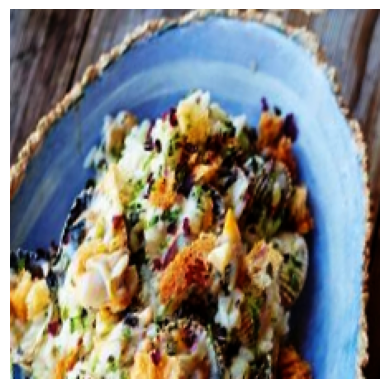

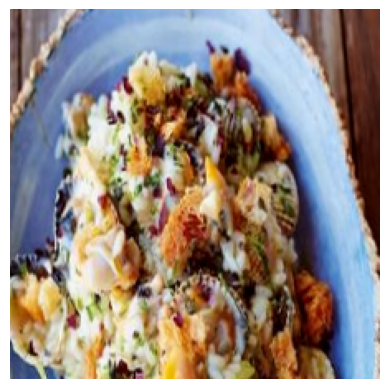

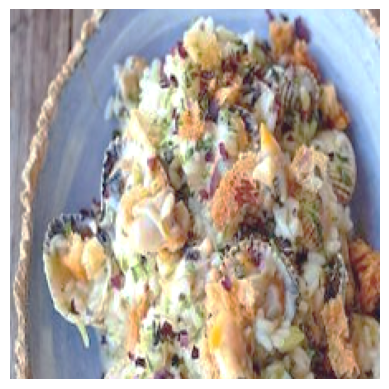

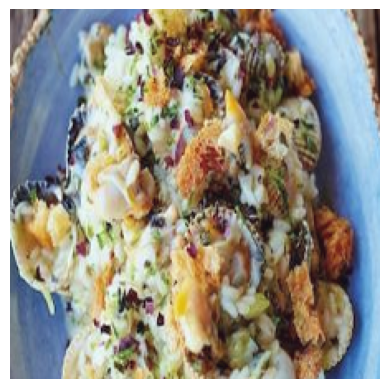

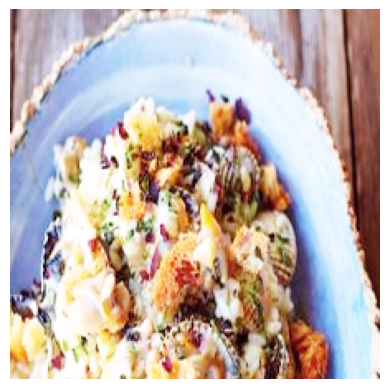

In [11]:
#visualizing some transformation
for e in range(5):
    for ii, inputsAndlabels in enumerate(trainDL):
        if ii==1: break
        for i in inputsAndlabels[0]:
            ImageDataset.visualize_image(i)
            break

## Supervised Finetuning

In [12]:
num_epochs = 10

for epoch in tqdm(range(num_epochs)):

    model.train()#Set the module in training mode.
    running_loss = 0.0

    for inputs, labels in tqdm(trainDL):
        print("new batch")
        labels = [int(label) for label in labels]
        inputs = inputs.to(device) 
        labels = torch.tensor(labels, dtype=torch.long).to(device)        
        # Zero the parameter gradients
        optimizer.zero_grad()        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()        
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainDL)}')

  0%|          | 0/10 [00:00<?, ?it/s]

new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


 10%|█         | 1/10 [14:05<2:06:49, 845.55s/it]

Epoch 1/10, Loss: 5.531155450003488


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


 20%|██        | 2/10 [27:44<1:50:39, 829.89s/it]

Epoch 2/10, Loss: 5.177072472042507


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


 30%|███       | 3/10 [41:25<1:36:19, 825.62s/it]

Epoch 3/10, Loss: 4.6572351985507545


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


 40%|████      | 4/10 [55:05<1:22:21, 823.56s/it]

Epoch 4/10, Loss: 4.152199347813924


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


 50%|█████     | 5/10 [1:08:45<1:08:31, 822.28s/it]

Epoch 5/10, Loss: 3.678534852133857


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


 60%|██████    | 6/10 [1:22:23<54:43, 820.89s/it]  

Epoch 6/10, Loss: 3.255826855462695


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


 70%|███████   | 7/10 [1:36:03<41:01, 820.60s/it]

Epoch 7/10, Loss: 2.839305393279545


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


 80%|████████  | 8/10 [1:49:43<27:20, 820.24s/it]

Epoch 8/10, Loss: 2.483183919437348


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


 90%|█████████ | 9/10 [2:03:21<13:39, 819.72s/it]

Epoch 9/10, Loss: 2.1406127763172935


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


new batch


100%|██████████| 10/10 [2:17:00<00:00, 822.09s/it]

Epoch 10/10, Loss: 1.827625694729033


In [13]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in tqdm(testDL):
        labels = [int(label) for label in labels]
        inputs, labels = inputs.to(device), torch.tensor(labels, dtype=torch.long).to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
cm = confusion_matrix(all_labels, all_preds)

print(f'Accuracy: {100 * correct / total}%')
np.save('cmResNet50PreTrainedAugmented10Epochs.npy',cm)
torch.save(model, "finetunedResNet50Augmented1.pth")


100%|██████████| 94/94 [15:18<00:00,  9.77s/it]

Accuracy: 0.3001500750375188%
